assume notebook in the style of [anl_get_commits.ipynb](https://colab.research.google.com/drive/1KVCVwkmQUdJb2pS2r8p9Gyi0t7CYzHkV?usp=sharing#scrollTo=c8nKzlPmaaKq) by fickas@cs.uoregon.edu has been run to generate appropriate .csv file.

In [ ]:
from google.colab import drive 
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
ls /content/

drive/  sample_data/


In [ ]:
ls -a /content/drive/

'My Drive'/   .shortcut-targets-by-id/   .Trash/


In [ ]:
ls -a /content/drive/My\ Drive/SortedCommits

moose_sorted_commits.csv  spack_sorted_commits.csv


In [ ]:
path = '/content/drive/My Drive/SortedCommits/moose_sorted_commits.csv'

In [ ]:
import pandas as pd 
moose_sorted_commits = pd.read_csv("/content/drive/My Drive/SortedCommits/moose_sorted_commits.csv").drop(columns=['Unnamed: 0'])

In [ ]:
moose_sorted_commits.head()

,year,month,day,doy,dow,full_date,files,message,person,locc
0,2008,6,10,162,Tuesday,2008-06-10 14:45:00+00:00,"['a/.gitignore b/.gitignore', 'a/COPYING b/COP...","Starting MOOSE project - adding license, c...",b'Cody Permann <codypermann@gmail.com>',1243
1,2008,6,10,162,Tuesday,2008-06-10 15:01:21+00:00,['a/framework/Makefile b/framework/Makefile'],Fix Makefile\n \n r111\n,b'Derek Gaston <derek.gaston@inl.gov>',5
2,2008,6,10,162,Tuesday,2008-06-10 14:47:02+00:00,"['a/framework/Makefile b/framework/Makefile', ...",Add stroma\n \n r110\n,b'Derek Gaston <derek.gaston@inl.gov>',72
3,2008,6,11,163,Wednesday,2008-06-11 10:18:20+00:00,['a/framework/Makefile.export b/framework/Make...,Fix Skagia makefile to link against Stroma...,b'Derek Gaston <derek.gaston@inl.gov>',1
4,2008,6,11,163,Wednesday,2008-06-11 07:36:16+00:00,['a/framework/Makefile.export b/framework/Make...,Intial Skagia commit\n \n r112\n,b'Derek Gaston <derek.gaston@inl.gov>',11



Given a time window (say a year)

*   Precompute repository contributors
*   Precompute list of files in repo 
*   Step through list commits, increment user entry in vector with number of contributors as length if user modified file in current commit 
*   Visualize data



compute list of contributors along with their commits as panda dfs in given year. 

In [ ]:
import sys 
def sorted_people_yearly_commits(year):
  """return list of commits per user as panda dataframes (slices of the original) sorted in descending order by rows. Filter out users with no commits

  param  : year as time window from which to search 
  
  """
  people_commits = []
  seen = {}
  for i in range(len(moose_sorted_commits['person'].index)):
    try:
      throw_away = seen[moose_sorted_commits['person'][i]]
      if throw_away == 1:
        continue 
    except KeyError:
      seen[moose_sorted_commits['person'][i]] = 1
      commits_by_p = moose_sorted_commits[(moose_sorted_commits['year'] == year) & (moose_sorted_commits['person'] == moose_sorted_commits['person'][i])]
      people_commits.append(commits_by_p)
  people_commits = list(filter(lambda x: len(x['full_date']) > 0, people_commits))
  people_commits.sort(key=lambda x: len(x['full_date']), reverse=True) #this doesn't work for some reason
  return people_commits

In [ ]:
sorted_people_yearly_commits(2008)[1].head()

,year,month,day,doy,dow,full_date,files,message,person,locc
57,2008,9,5,249,Friday,2008-09-05 11:50:05+00:00,['a/framework/include/VacuumBC.h b/framework/i...,trivial change in comment of Vacuum BC\n ...,b'Ryosuke Park <ryosuke.park@inl.gov>',2
58,2008,9,5,249,Friday,2008-09-05 07:24:42+00:00,['a/framework/include/VacuumBC.h b/framework/i...,Adding Vacuum BC and Cross-section definit...,b'Ryosuke Park <ryosuke.park@inl.gov>',46
59,2008,9,8,252,Monday,2008-09-08 21:28:10+00:00,['a/framework/include/materials/Constant.h b/f...,adding neutron velocity parameter into mat...,b'Ryosuke Park <ryosuke.park@inl.gov>',3
60,2008,9,8,252,Monday,2008-09-08 14:23:27+00:00,['a/framework/include/Reaction.h b/framework/i...,fixing Reaction kernel\n \n r270\n,b'Ryosuke Park <ryosuke.park@inl.gov>',4
61,2008,9,8,252,Monday,2008-09-08 14:06:09+00:00,['a/framework/include/Reaction.h b/framework/i...,adding generic reaction kernel\n \n ...,b'Ryosuke Park <ryosuke.park@inl.gov>',31


compute list of unique files in given year along with how many commits they appear in

In [ ]:
def files_in_year(year):
  """return list of (file, count) tuples sorted by count

  param  : year as time window 
  """
  ppl_commits = sorted_people_yearly_commits(year)
  seen = {}
  for i in range(len(ppl_commits)):
    df = ppl_commits[i]
    file_lists = [eval(l) for l in list(df['files'])]
    for l_file in file_lists:
      for file in l_file:
        try:
          seen[file] += 1
        except KeyError:
          seen[file] = 1 
  seen_sorted = sorted(seen.items(), key=lambda x : x[1], reverse=True)
  return seen_sorted 

In [ ]:
files_in_year(2008)[:10]

[('a/framework/include/Kernel.h b/framework/include/Kernel.h', 34),
 ('a/framework/Makefile b/framework/Makefile', 11),
 ('a/framework/src/Kernel.C b/framework/src/Kernel.C', 10),
 ('a/framework/include/materials/Material.h b/framework/include/materials/Material.h',
  8),
 ('a/framework/src/materials/PorousMedia.C b/framework/src/materials/PorousMedia.C',
  8),
 ('a/framework/include/BCFactory.h b/framework/include/BCFactory.h', 7),
 ('a/framework/src/Moose.C b/framework/src/Moose.C', 7),
 ('a/framework/include/materials/PorousMedia.h b/framework/include/materials/PorousMedia.h',
  5),
 ('a/framework/include/materials/Constant.h b/framework/include/materials/Constant.h',
  4),
 ('a/framework/Makefile.export b/framework/Makefile.export', 3)]

start computing 2d array of (file_count, user_count) pairs as you step through commit history.

In [ ]:
def make_indices(year):
  """return {file : file_rank}
     , {person : person_rank}
     , list of (file, count) tuples sorted by count
     , list of commits per user as panda dataframes (slices of the original) sorted in descending order by rows.

  param  : year as time window  
  """
  files   = files_in_year(year)
  commits = sorted_people_yearly_commits(year)
  f_index_year = {u[0] : files.index(u) for u in files}
  ppl_index_year = {list(commits[i]['person'])[0] : i for i in range(len(commits))}
  return f_index_year, ppl_index_year, files, commits 

In [ ]:
def make_user_file_mat(year):
  """return {file : file_rank}
     , {person : person_rank}

  param : year as time window
  """
  f_index, ppl_index, files, commits = make_indices(year)
  file_user_mat = [[0 for i in ppl_index] for f in f_index] 
  for i in range(len(commits)):
    df = commits[i]
    file_lists = [eval(l) for l in list(df['files'])]
    for file_l in file_lists:
      for f in file_l:
        if f in f_index:
          file_user_mat[f_index[f]][ppl_index[list(df['person'])[0]]] += 1
  return f_index, ppl_index, file_user_mat 

In [ ]:
f_index, ppl_index, mat = make_user_file_mat(2008)

In [ ]:
print(mat[:10])

[[27, 6, 0, 1, 0, 0], [10, 0, 1, 0, 0, 0], [8, 2, 0, 0, 0, 0], [1, 7, 0, 0, 0, 0], [0, 6, 0, 0, 2, 0], [6, 1, 0, 0, 0, 0], [2, 4, 1, 0, 0, 0], [1, 4, 0, 0, 0, 0], [2, 2, 0, 0, 0, 0], [3, 0, 0, 0, 0, 0]]


Turn above data into pandas dataframe and use [seaborn](https://seaborn.pydata.org/#:~:text=Seaborn%20is%20a%20Python%20data,attractive%20and%20informative%20statistical%20graphics.) and [matplotlib's pyplot](https://matplotlib.org/users/pyplot_tutorial.html) to plot heatmap of top rows and values.

In [ ]:
def make_pandas_df(year):
  f_index, ppl_index, file_user_mat = make_user_file_mat(year)
  index_labels  = list(f_index.keys()) 
  column_labels = list(ppl_index.keys()) 
  to_return = pd.DataFrame.from_records(file_user_mat, index=index_labels, columns=column_labels)
  return to_return 

In [ ]:
mat_df = make_pandas_df(2009)

In [ ]:
heat_df_example = mat_df.head(n=10) 
heat_df_example

,b'Cody Permann <cody.permann@inl.gov>',b'Derek Gaston <derek.gaston@inl.gov>',b'Ryosuke Park <ryosuke.park@inl.gov>',b'Vanessa Gertman <vanessa.gertman@inl.gov>',b'William Taitano <william.taitano@inl.gov>',b'Samet Kadioglu <samet.kadioglu@inl.gov>',b'John Peterson <jw.peterson@inl.gov>',b'Richard Williamson <richard.williamson@inl.gov>'
a/framework/include/Moose.h b/framework/include/Moose.h,6,6,6,0,0,0,0,0
a/framework/Makefile b/framework/Makefile,3,8,0,0,0,0,0,0
a/framework/include/Kernel.h b/framework/include/Kernel.h,0,5,2,1,1,0,0,0
a/framework/src/Moose.C b/framework/src/Moose.C,4,3,0,0,0,1,0,0
a/framework/src/ComputeJacobian.C b/framework/src/ComputeJacobian.C,1,3,2,0,0,0,1,0
a/framework/include/AuxFactory.h b/framework/include/AuxFactory.h,0,3,0,4,0,0,0,0
a/framework/src/Kernel.C b/framework/src/Kernel.C,0,0,4,0,2,0,0,0
a/framework/include/materials/Material.h b/framework/include/materials/Material.h,3,1,1,0,0,0,0,0
a/modules/combined/src/base/Elk.C b/modules/combined/src/base/Elk.C,2,3,0,0,0,0,0,0
a/framework/include/utils/ColumnMajorMatrix.h b/framework/include/utils/ColumnMajorMatrix.h,3,2,0,0,0,0,0,0


In [ ]:
import seaborn as sb 
import matplotlib.pyplot as plt 

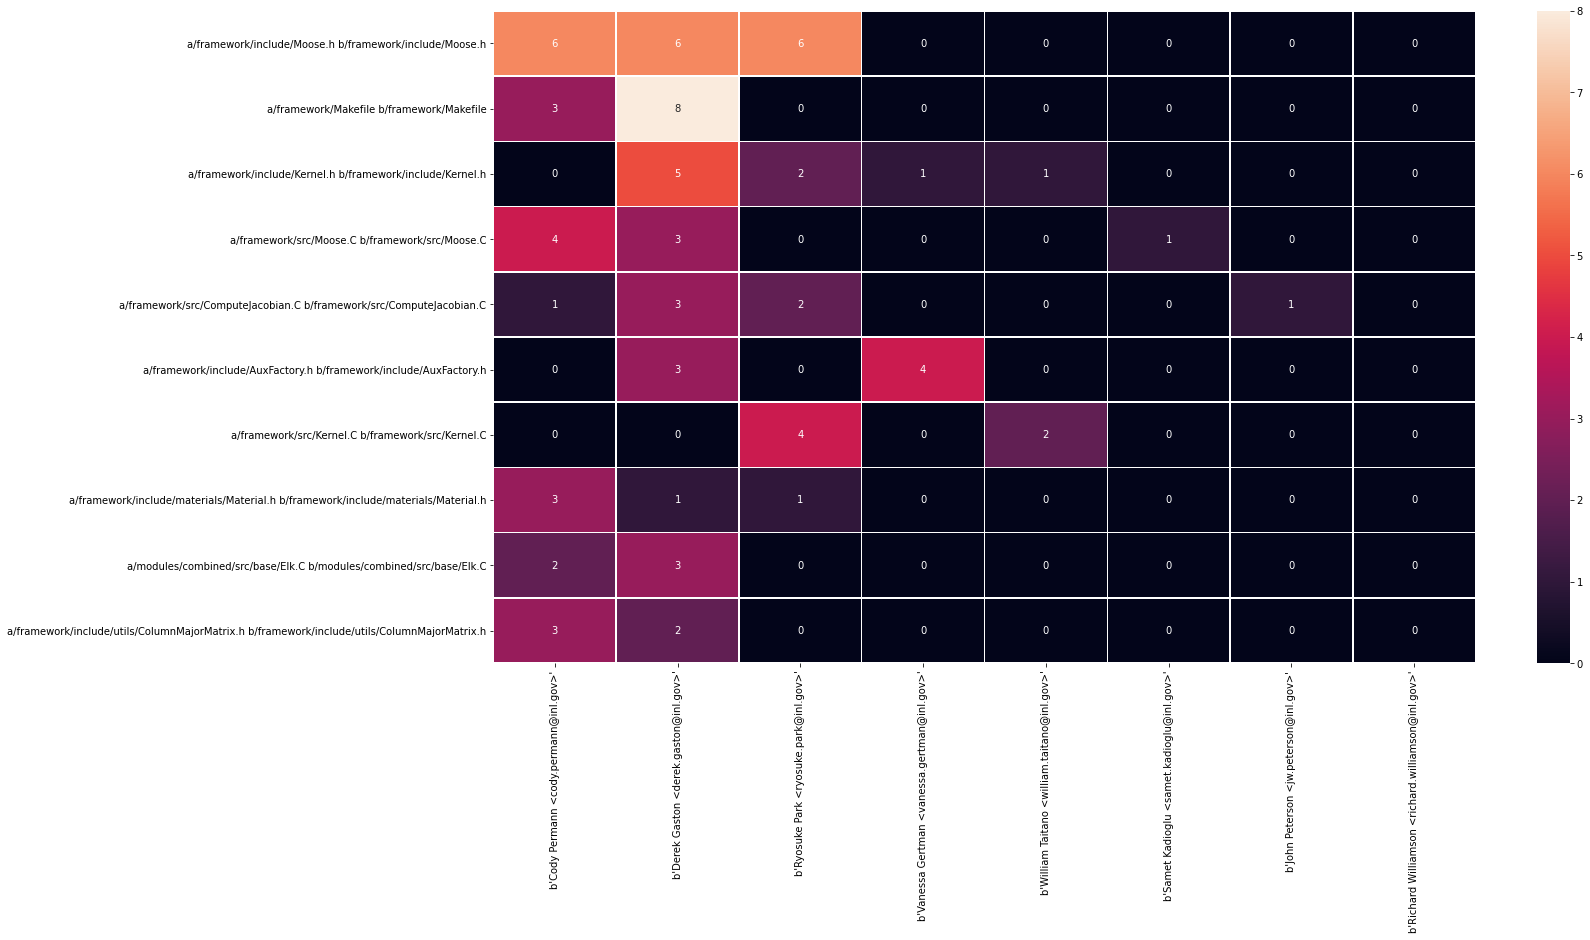

In [ ]:
fig, ax = plt.subplots(figsize=(22,12))
sb.heatmap(heat_df_example, annot=True, linewidths=.5)
plt.show()

I suspect that a visualization such as the above can inform us of something like a hiearchy of who can do what in a given project. For example, this codypermann person (in 2009) must have been  important for moose as he seems to be able to heavily touch files that very few (if any) other users ever touch---The Makefile for example (could also probably be interesting to look at how individuals access to "important" files have changed over time).

**side note: ** something fishy about the number of commits per user must be going on. github differentiates between the "author" of a commit, vs its "committer" vs its "pusher". I suspect this data must be using "committer"s. I wonder how different the heatmap would be were we using "authors" instead. 

(*i.e*): the differences between the different types of people being as described by [this github staff answer](https://github.community/t/why-is-my-commit-associated-with-the-wrong-person/10199). I also think that one can probably, with high accuracy, infer teams, and team leaders by analysing the disparities between authors, committers, and pushers.

**N.B** it seems to me that patterns such as: ["bit-twiddling", "in the zone", or "busy body"](https://docs.google.com/document/d/1IbkpdkU0mWhCLMp19q0yuhwH4ixwFWRhTlTdU8Okg1s/edit) could probably be infered from above 2d array especially if time dimension was incorporated.